## Siguiente approach: usar PCA y una red neuronal densa.

Importacion de librerias

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [6]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
columns = ["tension"]

Visualizacion de medicion.

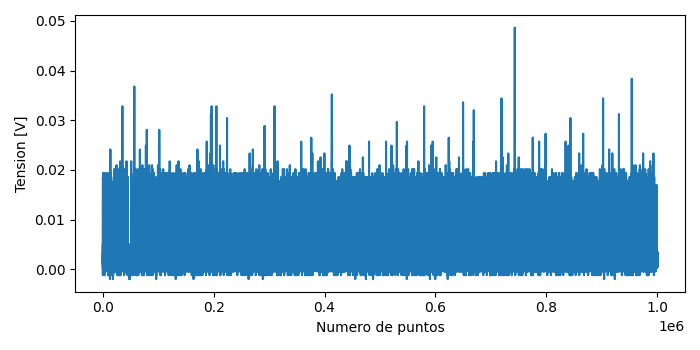

In [7]:
%matplotlib widget
dat = pd.read_csv("5.Wfm.csv", sep = ';')
dat.columns = columns
dat = -dat
plt.figure()
plt.plot(dat.tension)
plt.xlabel("Numero de puntos")
plt.ylabel("Tension [V]")
plt.show()

Aca separo los pulsos y los guardo en el array VecPulses[], esto es simplemente poner un threshold que indica que hay un foton. Si no supero el threshold, avanzo un punto, si lo encuentro, avanzo 50 ns (50 puntos) que corresponde al tiempo de respuesta del MPPC y donde se supone que no deberia haber otro foton, salvo en el caso de AfterPulse.

1 Gsample/s -> 1 ns = 1 sample

In [8]:
num_puntos = 60
punto_final = 50 
threshold_1foton = 0.013

VecPulses = np.zeros((0,num_puntos))
Pulse = np.zeros(num_puntos)
k = 0
i = 100
while i< dat.size-500:
    if dat.tension[i] > threshold_1foton:
        k=k+1
        for j in range(num_puntos):
            Pulse[j] = dat.tension[i+j-(num_puntos-punto_final)]
        VecPulses = np.append(VecPulses, Pulse)
        VecPulses = VecPulses.reshape((k,num_puntos))
        i = i+punto_final
        
        continue
    else:
        i += 1
        continue

Codigo para visualizar los pulsos uno por uno.

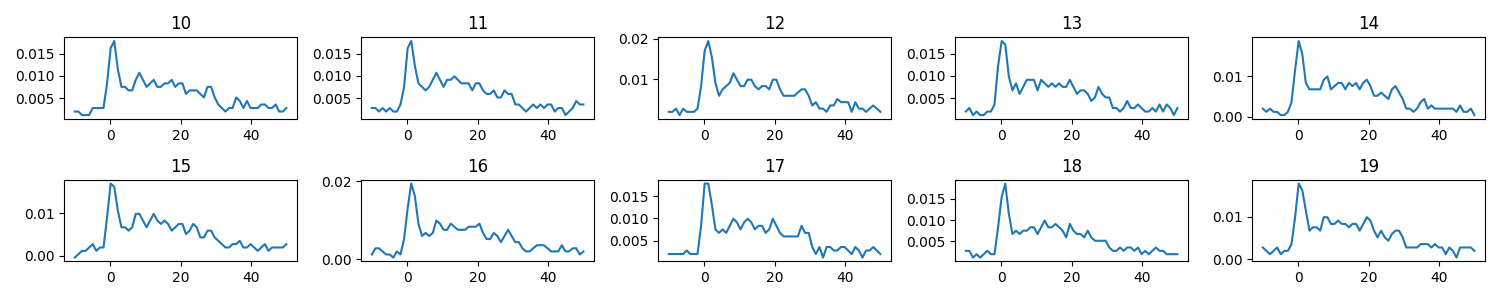

In [9]:
t = np.linspace(punto_final-num_puntos, punto_final, num_puntos)
m = 1
m = m-1
plt.close()
plt.figure(figsize=(15,3))
for l in range(10+m*10,20+m*10):
    plt.subplot(2,5, l+1-(10+m*10))
    plt.plot(t, VecPulses[l])
    plt.title(l)

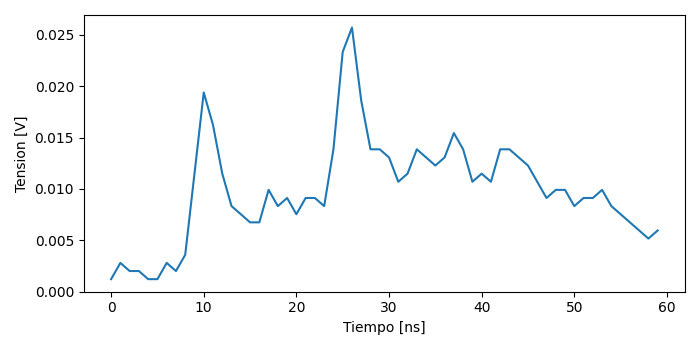

In [11]:
buffer = pd.read_csv("1_a.csv")
columns = ["time", "tension"]
buffer.columns = columns
plt.close()
plt.figure()
plt.plot(buffer.time, buffer.tension)
plt.xlabel("Tiempo [ns]")
plt.ylabel("Tension [V]")
plt.show()

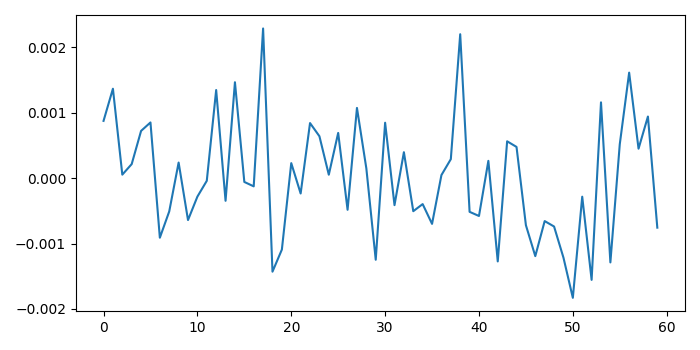

In [12]:
white_noise = np.random.normal(0, 0.001, num_puntos)
plt.close()
plt.figure()
plt.plot(white_noise)

Esta parte es de data augmentation. Debido a que es dificil encontrar datos a mano para entrenar la red, ya que son mas bien raros, me canse a los 35 de cada uno y decidi sumarles ruido para obtener un total de 350 pulsos de cada tipo para entrenar las redes.

In [18]:
datos_pulso = np.zeros((350, num_puntos))
datos_afterpulse = np.zeros((350, num_puntos))
datos_doble_pulso = np.zeros((350, num_puntos))
columns = ["time", "tension"]

for i in range(35):
    dat_p = pd.read_csv(str(i+1)+"_f.csv")
    dat_p.columns = columns
    datos_pulso[i] = dat_p.tension
    dat_a = pd.read_csv(str(i+1)+"_a.csv")
    dat_a.columns = columns
    datos_afterpulse[i] = dat_a.tension
    dat_d = pd.read_csv(str(i+1)+"_d.csv")
    dat_d.columns = columns
    datos_doble_pulso[i] = dat_d.tension

for i in range(35,350,1):
    white_noise = np.random.normal(0, 0.001, num_puntos)
    dat_p = pd.read_csv(str(i%35+1)+"_f.csv")
    dat_p.columns = columns
    datos_pulso[i] = dat_p.tension + white_noise
    dat_a = pd.read_csv(str(i%35+1)+"_a.csv")
    dat_a.columns = columns
    datos_afterpulse[i] = dat_a.tension+white_noise
    dat_d = pd.read_csv(str(i%35+1)+"_d.csv")
    dat_d.columns = columns
    datos_doble_pulso[i] = dat_d.tension+white_noise


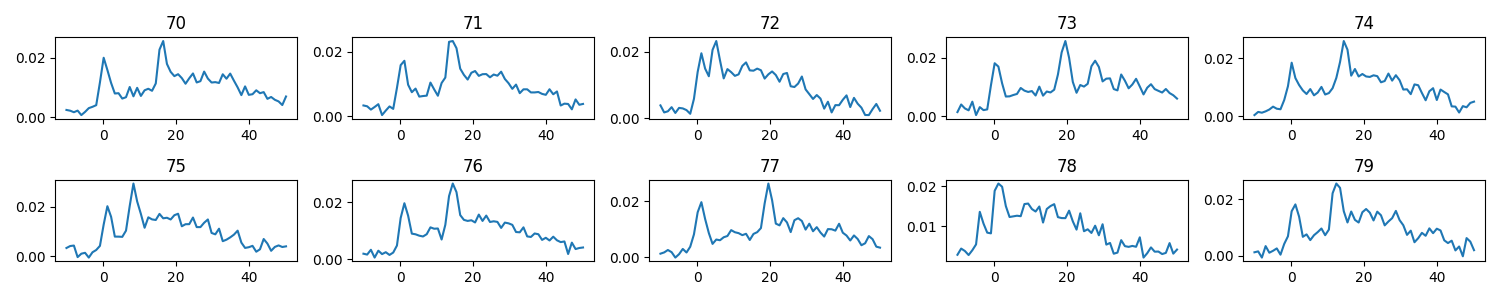

In [19]:
t = np.linspace(punto_final-num_puntos, punto_final, num_puntos)
m = 7
m = m-1
plt.close()
plt.figure(figsize=(15,3))
for l in range(10+m*10,20+m*10):
    plt.subplot(2,5, l+1-(10+m*10))
    plt.plot(t, datos_afterpulse[l])
    plt.title(l)

Aca hago el PCA. Use n = 2 componentes. Vemos que los tres tipos de datos se pueden distinguir bien con tan solo 2 componentes principales.


Varianza explicada por cada componente principal: [0.36508766 0.15827449]
Varianza total explicada: 0.523362153834811


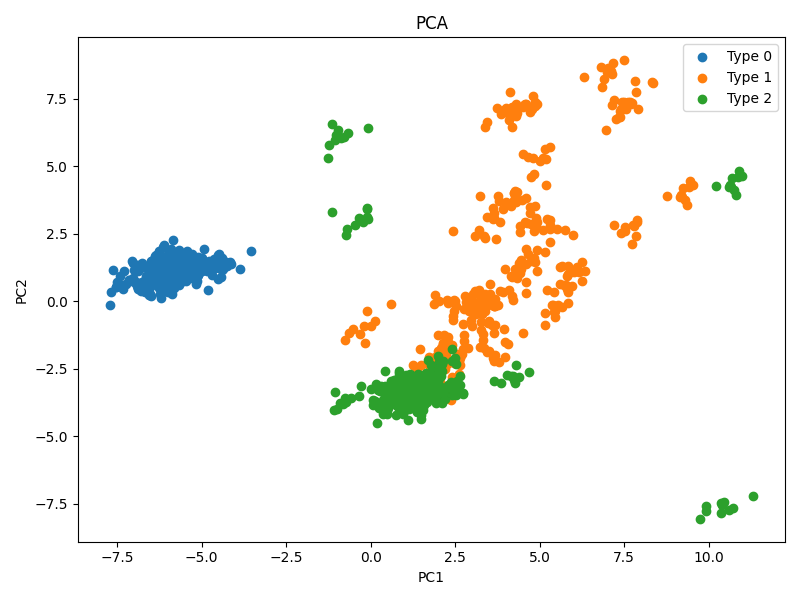

In [35]:
data = np.vstack((datos_pulso, datos_afterpulse, datos_doble_pulso))

labels_type1 = np.zeros((350, 1))
labels_type2 = np.ones((350, 1))
labels_type3 = np.full((350, 1), 2)
labels = np.vstack((labels_type1, labels_type2, labels_type3))

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

n_components = 2  
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_scaled)

print(f'Varianza explicada por cada componente principal: {pca.explained_variance_ratio_}')
print(f'Varianza total explicada: {sum(pca.explained_variance_ratio_)}')

labels = labels.flatten()

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.scatter(data_pca[labels == i, 0], data_pca[labels == i, 1], label=f'Type {i}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA')
plt.legend()
plt.show()


In [29]:
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(data_pca, labels, test_size=0.2, random_state=11)

# one hot
y_train_pca = tf.keras.utils.to_categorical(y_train_pca, num_classes=3)
y_test_pca = tf.keras.utils.to_categorical(y_test_pca, num_classes=3)

model_pca = models.Sequential()

model_pca.add(layers.Dense(64, activation='relu', input_shape=(n_components,))) ## entrada a la red, numero de componentes
model_pca.add(layers.Dense(32, activation='relu'))
model_pca.add(layers.Dense(3, activation='softmax'))

model_pca.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_pca = model_pca.fit(x_train_pca, y_train_pca, epochs=100, batch_size=32, validation_split=0.2)

test_loss_pca, test_acc_pca = model_pca.evaluate(x_test_pca, y_test_pca)
print(f'Test accuracy using PCA: {test_acc_pca}')

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4103 - loss: 1.1709 - val_accuracy: 0.8988 - val_loss: 0.5125
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9047 - loss: 0.4355 - val_accuracy: 0.9107 - val_loss: 0.3254
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9008 - loss: 0.2922 - val_accuracy: 0.9107 - val_loss: 0.2876
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8985 - loss: 0.3003 - val_accuracy: 0.9167 - val_loss: 0.2656
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9332 - loss: 0.2061 - val_accuracy: 0.9167 - val_loss: 0.2586
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9271 - loss: 0.2444 - val_accuracy: 0.9345 - val_loss: 0.2411
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9236 - loss: 0.1877 - val_accuracy: 0.9226 - val_loss: 0.2408
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9369 - loss: 0.2036 - val_accuracy: 0.9405 - 

In [12]:
model_pca.save('model_pca_dense.h5')

Evaluacion del modelo:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9721 - loss: 0.0735 
Precisión en el conjunto de prueba: 0.961904764175415


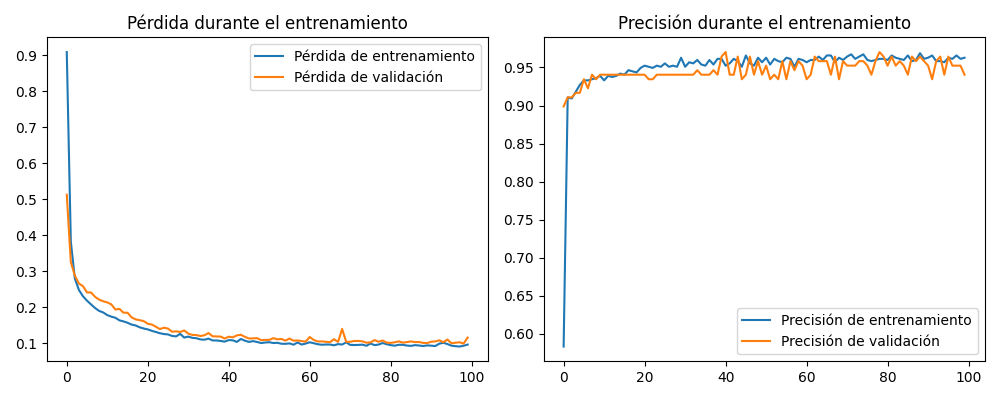

In [30]:

test_loss, test_accuracy = model_pca.evaluate(x_test_pca, y_test_pca)
print("Precisión en el conjunto de prueba:", test_accuracy)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_pca.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history_pca.history['val_loss'], label='Pérdida de validación')
plt.legend()
plt.title('Pérdida durante el entrenamiento')

plt.subplot(1, 2, 2)
plt.plot(history_pca.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history_pca.history['val_accuracy'], label='Precisión de validación')
plt.legend()
plt.title('Precisión durante el entrenamiento')

plt.show()

Prueba y predicciones del modelo:

In [31]:
double_count = 0
after_count = 0
after_pulsos = np.ndarray((100,60))
double_pulsos = np.ndarray((100,60))
for i in range(VecPulses.shape[0]):
    new_data_scaled = scaler.transform(VecPulses[i].reshape(1, -1))
    new_data_pca = pca.transform(new_data_scaled)
    new_prediction = model_pca.predict(new_data_pca, verbose=0)
    if(np.argmax(new_prediction) == 1):
        after_pulsos[after_count] = VecPulses[i]
        after_count = after_count +1
        print("El pulso "+str(i) +" es un afterpulse.")
    if(np.argmax(new_prediction) == 2):
        print("El pulso "+str(i) + " es un doble foton.")
        double_pulsos[double_count] = VecPulses[i]
        double_count = double_count+1

El pulso 20 es un doble foton.
El pulso 44 es un afterpulse.
El pulso 49 es un doble foton.
El pulso 68 es un doble foton.
El pulso 69 es un doble foton.
El pulso 71 es un doble foton.
El pulso 78 es un afterpulse.
El pulso 89 es un afterpulse.
El pulso 106 es un afterpulse.
El pulso 109 es un afterpulse.
El pulso 112 es un doble foton.
El pulso 128 es un afterpulse.
El pulso 153 es un afterpulse.
El pulso 157 es un doble foton.
El pulso 167 es un afterpulse.
El pulso 171 es un afterpulse.
El pulso 200 es un doble foton.
El pulso 212 es un afterpulse.
El pulso 243 es un afterpulse.
El pulso 254 es un afterpulse.
El pulso 255 es un doble foton.
El pulso 257 es un doble foton.
El pulso 259 es un doble foton.
El pulso 263 es un afterpulse.
El pulso 269 es un doble foton.
El pulso 275 es un afterpulse.
El pulso 284 es un afterpulse.
El pulso 304 es un doble foton.
El pulso 324 es un doble foton.
El pulso 368 es un afterpulse.
El pulso 371 es un doble foton.
El pulso 375 es un afterpulse.
E

In [32]:
print("Dobles: " + str(double_count) +"/"+str(VecPulses.shape[0]))
print("Afters: " + str(after_count) +"/"+str(VecPulses.shape[0]))

Dobles: 60/1282
Afters: 50/1282


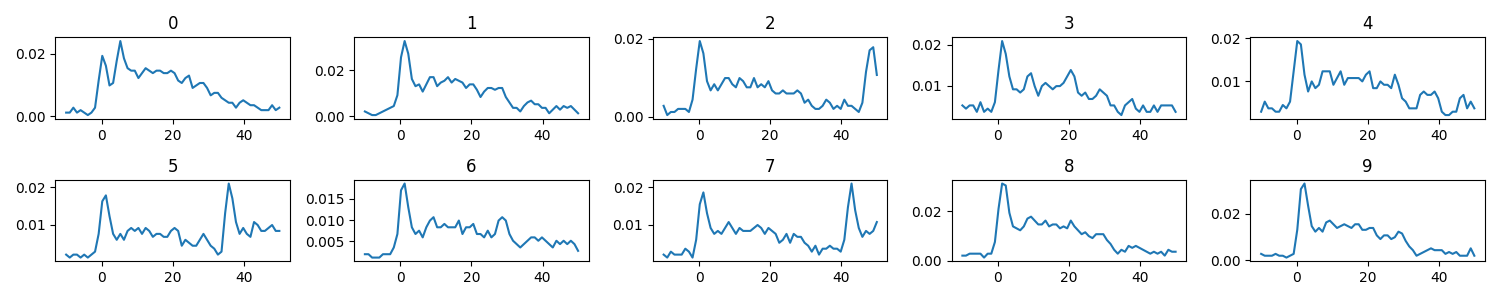

In [33]:
t = np.linspace(punto_final-num_puntos, punto_final, num_puntos)
m = 0
m = m-1
plt.close()
plt.figure(figsize=(15,3))
for l in range(10+m*10,20+m*10):
    plt.subplot(2,5, l+1-(10+m*10))
    plt.plot(t, double_pulsos[l])
    plt.title(l)

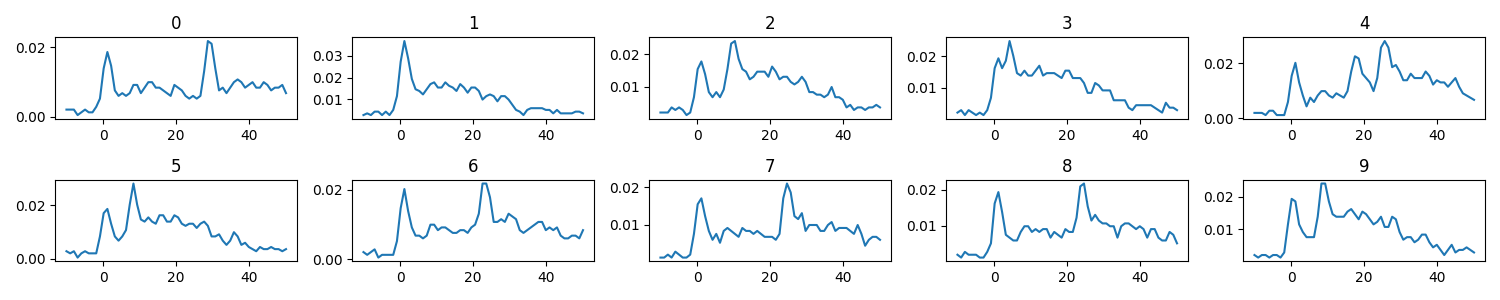

In [34]:
t = np.linspace(punto_final-num_puntos, punto_final, num_puntos)
m = 0
m = m-1
plt.close()
plt.figure(figsize=(15,3))
for l in range(10+m*10,20+m*10):
    plt.subplot(2,5, l+1-(10+m*10))
    plt.plot(t, after_pulsos[l])
    plt.title(l)